# 決定木から始める機械学習

この演習では，機械学習手法のひとつである決定木を使って，あらかじめ与えられたデータから，未知データを分類する規則を抽出・適用する**教師あり学習**を体験します．この演習で用いるデータは以下の通りです：

* （初回の演習で用いた）アヤメのデータ
* タイタニック号の乗船者データ

前回同様，本演習で必要となるライブラリを読み込んでおきましょう．
以下のコードを実行してください．

In [ ]:
!pip install graphviz
!pip install category_encoders

In [2]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 行列計算をおこなうためのライブラリ
import numpy as np

# 機械学習用ライブラリsklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from graphviz import Source

# その他
import category_encoders

# グラフ描画ライブラリ
import matplotlib.pyplot as plt
%matplotlib inline

---
## 例題1: アヤメ

決定木アルゴリズムを体験する題材として，K-meansの演習で用いた[アヤメのデータ](https://nbviewer.jupyter.org/github/trycycle/data-analysis-lecture-2019/blob/master/notebook/k-means.ipynb)を用いましょう．以下のコードを実行してデータを読み込みます．

In [3]:
from sklearn import datasets

# Iris（アヤメ）の大きさに関するデータをロード
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target_names[iris.target]

# 簡単のために，カラム名を修正しておく
iris_df = iris_df.rename(
    columns = {
        'sepal length (cm)': 'sepal_length',
        'sepal width (cm)': 'sepal_width',
        'petal length (cm)': 'petal_length',
        'petal width (cm)': 'petal_width'
    }
)

# 最初の数件を表示
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


このアヤメデータには，花弁の長さ・幅，がくの長さ・幅，品種が記されていたことを思い出しましょう．例題1の目標は，**花弁の長さ・幅，がくの長さ・幅から品種を推定する予測モデルを構築**することです．早速，決定木を用いて予測モデルを構築してみましょう．

一般に教師あり学習で予測を行うモデルを構築する際には，データを**学習用（訓練）データ**と**評価用データ**に分割してデータ分析を行います．以下のコードを実行して，先ほど用意したデータを学習用（70%）と評価用（30%）に分割します．

In [4]:
# データを学習用（70%）と評価用（30%）に分割する
iris_train_df, iris_test_df = train_test_split(
                                iris_df, test_size=0.3,
                                random_state=1,
                                stratify=iris_df.species)

変数``iris_test_df``には品種情報も含まれますが，予測モデルの性能評価の際には，品種情報が未知であるとして予測を行い，予測結果と（隠しておいた）品種情報を照らし合わせて評価することになります．

では，教師あり学習のひとつである決定木アルゴリズムを適用してみましょう．``iris_train_df``に決定木アルゴリズムを適用して，品種を見分けるルールを抽出（学習）しましょう．決定木アルゴリズムは`sklearn`ライブラリの``DecisionTreeClassifier``クラスを使って実行できます．下記コードを実行してみてください．

In [5]:
iris_train_df.iloc[:, 0:4]

,sepal_length,sepal_width,petal_length,petal_width
33,5.5,4.2,1.4,0.2
20,5.4,3.4,1.7,0.2
115,6.4,3.2,5.3,2.3
124,6.7,3.3,5.7,2.1
35,5.0,3.2,1.2,0.2
...,...,...,...,...
41,4.5,2.3,1.3,0.3
92,5.8,2.6,4.0,1.2
26,5.0,3.4,1.6,0.4
3,4.6,3.1,1.5,0.2


In [6]:
# X_trainは，品種（Species）以外のすべての指標
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X_train = iris_train_df[features]

# y_trainは品種の指標
y_train = iris_train_df.species

# 学習
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

品種を予測するルールが学習されました．予測ルールをわかりやすく可視化してみましょう．以下のコードを実行してみてください．

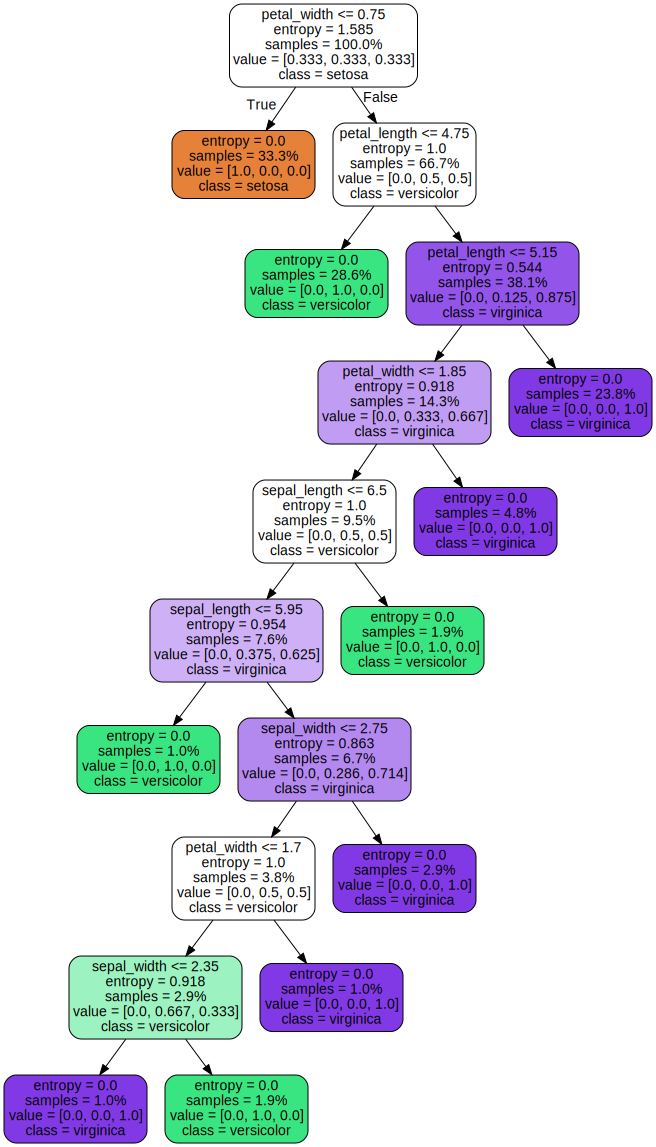

In [7]:
Source(export_graphviz(model, out_file=None,
                       feature_names=features,
                       class_names=['setosa', 'versicolor', 'virginica'],
                       proportion=True,
                       filled=True, rounded=True # 見た目の調整
                      ))

分類ルールが木のように枝分かれした形で可視化されました．この可視化結果が，今回の教師あり学習アルゴリズムが **決定「木」** と呼ばれる所以です．

結果の見方ですが，各四角が分類ルールの分岐をあわらしています．四角の下に書かれた文字情報が分岐条件を示しています．四角中に書かれた文字は，四角に至るまでに適用された分岐条件を満たすと，
* その条件を満たすデータが全体の何パーセントあるか
* ラベルごとの分類結果の割合が何パーセントか

を示しています．例えば，上図の上から3段目の左にある「class=virsicolor, value=\[0.0, 1.00, 0.0\]」という四角は，
* 花びら（petal）の長さが2.6より大きいかつ4.75以下の場合，その個体は100%の確率でvirsicolorであること
* この条件にマッチする個体はデータセットに28.6%存在すること

を示しています．

さて，ここまでやったことは予測のためのルール（モデル）の構築でした．構築した予測モデルを使って，未知のデータを予測してみましょう．この例題の冒頭で，変数``iris_test_df``に**予測モデルの構築に使われていないデータ**を別途用意していたことを思い出しましょう．

In [8]:
# 最初の数件を表示
iris_test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
148,6.2,3.4,5.4,2.3,virginica
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
106,4.9,2.5,4.5,1.7,virginica
75,6.6,3.0,4.4,1.4,versicolor


先ほど構築した予測モデルをこの``iris_test_df``に適用して，未知データのアヤメの品種を予測してみましょう．構築した予測モデル``iris_model``を用いて未知データを予測するには``predict``関数を用います．

In [9]:
# 評価用データの特徴量と正解ラベルを取得
X_test = iris_test_df[features]
y_test = iris_test_df.species

# 予測モデルを使って，品種が未知の個体の品種を推定
iris_predicted = model.predict(X_test)

# 予測結果の一部を表示
iris_predicted

array(['virginica', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'versicolor', 'virginica', 'versicolor', 'virginica', 'setosa',
       'setosa', 'virginica', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'virginica', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'setosa', 'versicolor', 'virginica', 'versicolor',
       'versicolor', 'versicolor', 'virginica', 'setosa', 'virginica',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'virginica',
       'virginica', 'setosa', 'setosa', 'setosa', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'setosa', 'setosa'],
      dtype=object)

予測結果が変数``iris_predicted``に格納されました．``iris_test_df``の列``Species``には実際の品種情報が格納されていました．これと予測結果と照らし合わせて，予測性能を評価してみましょう．

予測性能の評価指標には様々なものがありますが，ここでは精度（accuracy）を計算しましょう．精度は「予測結果のうち， **各個体の品種について，予測モデルが予測したものと，実際の品種が一致したケースの割合」** を意味します．精度の計算には`sklearn`の`accuracy_score`関数を用います．第1引数に予測結果，第2引数に実際の結果を入力します．以下のコードを実行してみましょう．

In [10]:
accuracy_score(iris_predicted, iris_test_df.species)

0.9555555555555556

上記結果によると，Accuracyは97.8%を示しており，かなりの精度で品種を予測できていることが分かります．

---
## 例題2: タイタニック号の乗船者データ

1912年4月14日，処女航海中の豪華客船タイタニック号は多くの乗船者を乗せたまま沈没しました．タイタニックとその事故は，映画化されるなどして世界的に有名です．
乗船者に関する情報が残っていたために，事故後，多くの人が事故に関する分析を行いました．私たちもタイタニック号の乗船者情報を用いて，生死を分けた条件について分析を行ってみましょう．

以下のコードを実行して，タイタニック号の乗船者（の一部）のデータを読み込みましょう．

In [11]:
# データの読み込み
url = "http://drive.hontolab.org/ymc-lecture2020/data/titanic_train.csv"
titanic_df = pd.read_table(url, header=0, sep=",")

# 生存情報を分かりやすくする
titanic_df = titanic_df.assign(
    Survived = lambda df: df.Survived.map({1: 'survived', 0: 'died'})
)

# 最初の数件のみ表示
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,survived,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,survived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,survived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


様々な情報が表示されました．変数``titanic_train_df``に格納されたデータの属性（列名）の詳細は以下の通りです：

* PassengerId: 乗船者を識別するためのID
* Survived: ある乗船者が沈没事故で生き残った否かを示すフラグ．
* Pclass: チケットの等級．1は1等乗客，2は2等乗客，3は3等乗客を表す
* Name: 乗客名
* Sex: 性別
* Age: 年齢
* SibSp: タイタニック号に同乗した兄弟もしくは配偶者の数
* Parch: タイタニック号に乗船した両親もしくは子どもの数
* Ticket: チケット番号
* Fare: 乗船料金
* Cabin: 客室番号
* Embarked: 乗船した港．C = Cherbourg, Q = Queenstown, S = Southampton

このデータを用いて，どんな乗客が生き残れたのかを予測できるようにしましょう．

決定木を適用する前に，``titanic_df``データに対して簡易的な分析を行い，各データ属性と生存情報との関係を眺めてみましょう．
以下のコードを実行すると， **乗客の等級（Pclass）と生存の有無（Survived）** の属性の値を集計して，ある等級の乗客のうち生き残った方の割合が表示されます．

In [12]:
pd.crosstab(titanic_df['Survived'], titanic_df['Pclass'], normalize='columns')

Pclass,1,2,3
Survived,,,
died,0.37037,0.527174,0.757637
survived,0.62963,0.472826,0.242363


分析の結果，どうやら等級が高いほど生き残っている方の割合が大きいようです．等級以外の属性でも同様の分析を行ってみてください．例えば，性別（Sex）と生存の有無の関係は以下のコードで得られます．

In [13]:
pd.crosstab(titanic_df['Survived'], titanic_df['Sex'], normalize='columns')

Sex,female,male
Survived,,
died,0.257962,0.811092
survived,0.742038,0.188908


決定木アルゴリズムを適用する前に，データの欠損を確認しておきます．
収集したデータの一部が欠損していることはよくあることです．欠損値がデータに含まれると，機械学習のアルゴリズムがうまく動作しない場合があります．

欠損値がある場合の対応は，
* 欠損しているデータを捨てる
* 欠損値を代表的な値で埋める

といったアプローチが採られることが多いです．欠損しているデータを捨ててしまうと，学習に用いる貴重なデータが減りますので，今回は欠損値を代表値で埋めます．

まず，以下のコードを走らせて，欠損値を確認してみましょう．

In [14]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

上の結果から，Age，Cabin，Embarkedに欠損値が含まれるようです．Cabinは乗船客に与えられた固有の情報で，生存者の予測には役立ちません．それゆえ，AgeとEmbarkedのみ欠損値を埋めることにします．

欠損値を埋めるには様々な方法が提案されていますが，今回は
* Ageは中央値
* Embarkedは最頻値

で埋めることにします．以下のコードを実行してください．

In [15]:
# Embarkedの欠損を最頻値で埋める
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(titanic_df["Embarked"].mode().iloc[0]) 

# Ageを中央値で埋める
titanic_df["Age"] = titanic_df["Age"].fillna(titanic_df["Age"].median()) 

これで欠損値はなくなりました．
それでは決定木アルゴリズムを適用してみましょう．例題1と同様，まず，用意したデータを学習用（70%）と評価用（30%）に分割します．

In [16]:
# データを学習用（70%）と評価用（30%）に分割する
titanic_train_df, titanic_test_df = train_test_split(
                                        titanic_df, test_size=0.3,
                                        random_state=1,
                                        stratify=titanic_df.Survived)

変数``titanic_test_df``には生存の有無の情報も含まれますが，予測モデルの性能評価の際には，生存情報が未知であるとして予測を行い，予測結果と（隠しておいた）生存情報を照らし合わせて評価することになります．

簡易的な分析を行ってみると，生存の有無を識別するために有効な指標がありそうな気もします．しかし実際には，複数の指標が絡み合って生存の有無が決まっていると思われます．このような状況で，指標（特徴量）同士の複雑な関係性を考慮しながら，予測のためのルールを抽出するのが**教師あり学習**です．

早速，決定木アルゴリズムを適用してみましょう．まずは決定木を適用するデータを整形します．データを眺めると，氏名（Name）やチケット番号（Ticket），客室番号（Cabin）は各乗船者に固有に与えられた情報であることが分かります．これら特徴量は生存者の予測には役に立たないため，それ以外の情報を利用することにします．

下記コードを実行して，決定木を適用する際に注目する指標を，変数``target_features``に格納しておきます．さらに，
``titanic_train_df``から上記指標に関するデータのみを抽出します．

In [17]:
# 注目する指標
target_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

# 以下のように書けば，target_featuresの指標のみに注目してデータを抽出できる
titanic_train_df[target_features]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
472,2,female,33.0,1,2,27.7500,S
597,3,male,49.0,0,0,0.0000,S
843,3,male,34.5,0,0,6.4375,C
112,3,male,22.0,0,0,8.0500,S
869,3,male,4.0,1,1,11.1333,S
...,...,...,...,...,...,...,...
650,3,male,28.0,0,0,7.8958,S
241,3,female,28.0,1,0,15.5000,Q
265,2,male,36.0,0,0,10.5000,S
15,2,female,55.0,0,0,16.0000,S


性別（Sex）や乗船した港（Embarked）は数値情報ではなくカテゴリ情報です．多くの機械学習は数値を受け取って処理をするので，カテゴリ情報も数値情報に変換しておいた方が都合がよいです．ここでは，「EmbarkedがSであることをEmbarked_Sが1，EmbarkedがSでないことをEmbarked_S=0」となるような変換をおこなうことにします．

下記コードがその準備となります．

In [18]:
encoder = category_encoders.OneHotEncoder(cols=['Embarked', 'Sex'], use_cat_names=True)
encoder.fit(titanic_train_df[target_features])

/Users/yamamoto/.pyenv/versions/3.8.2/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


OneHotEncoder(cols=['Embarked', 'Sex'], use_cat_names=True)

それでは，``titanic_train_df``に決定木アルゴリズムを適用して，生存の有無のルールを抽出（学習）しましょう．決定木アルゴリズムは``DecisionTreeClassifier``クラスを用いて実行できます．下記コードを実行してみてください．

In [19]:
# 予測に用いる生存情報以外のすべての指標をX_trainに
X_train = titanic_train_df[target_features]

# カテゴリ変数を数値情報に変換
X_train = encoder.transform(X_train)

# y_trainは生存有無をあらわす指標
y_train = titanic_train_df.Survived

# 学習
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=3) # 木の深さを3に限定
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

生存の有無を予測するルールが学習されました．生存の有無を予測するためのルールをわかりやすく可視化してみましょう．以下のコードを実行してみてください．

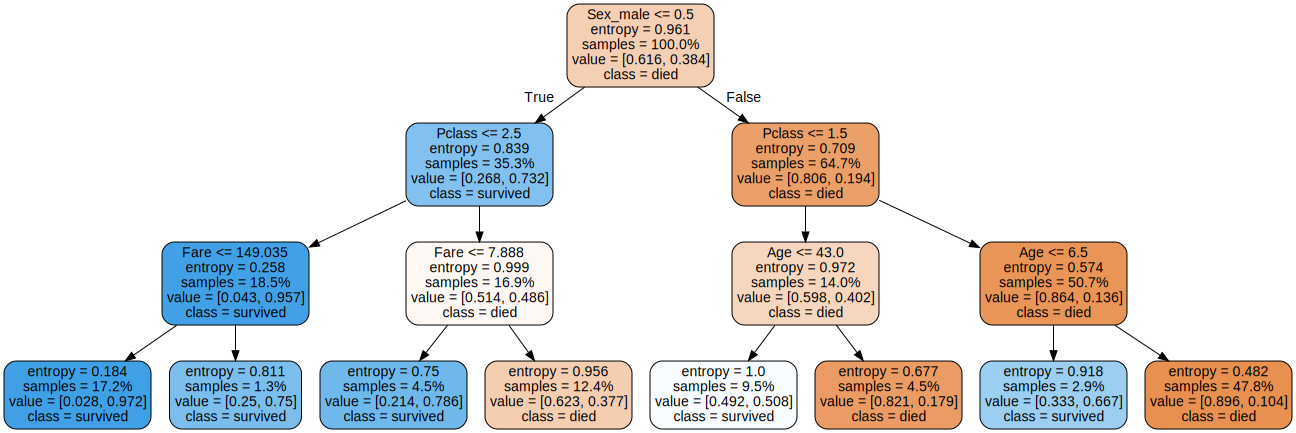

In [20]:
Source(export_graphviz(model, out_file=None,
                       feature_names=X_train.columns,
                       class_names=['died', 'survived'],
                       proportion=True,
                       filled=True, rounded=True # 見た目の調整
                      ))

分類ルールが得られました．

結果を解釈してみましょう．例えば，上図の上から3段目，左から1番目にある「class=survived, entropy=0.258」という四角は，
* 性別が女性であり（Sex_male<=0.5: True），乗船クラスが1等もしくは2等クラス（Pclass<=2.5: True）の乗客は95.7%の確率で生存したこと
* その条件にマッチする乗客は，全体の18.5%存在すること

を示しています．

なんとなく予測ルールは分かりましたが，各指標が予測にどの程度影響があるかを調べてみましょう．以下のコードを実行します．

In [21]:
for feature, importance in zip(X_train.columns, model.feature_importances_):
    print("{}\t{}".format(feature, importance))

Pclass	0.2907129831238367
Sex_female	0.0
Sex_male	0.5350835392973032
Age	0.1165652637163436
SibSp	0.0
Parch	0.0
Fare	0.05763821386251649
Embarked_S	0.0
Embarked_C	0.0
Embarked_Q	0.0


この結果からも，**性別**や**等級**が生存に大きく影響を与えていたことがうかがえます．

さて，ここまでやったことは予測のためのルール（モデル）の構築でした．構築した予測モデルを使って，未知のデータを予測してみましょう．この例題の冒頭で，変数``titanic_test_df``に**予測モデルの構築に使われていないデータ**を別途用意していたことを思い出しましょう．

In [22]:
# 最初の数件を表示
titanic_test_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
433,434,died,3,"Kallio, Mr. Nikolai Erland",male,17.0,0,0,STON/O 2. 3101274,7.125,NaN,S
221,222,died,2,"Bracken, Mr. James H",male,27.0,0,0,220367,13.000,NaN,S
217,218,died,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,243847,27.000,NaN,S
376,377,survived,3,"Landergren, Miss. Aurora Adelia",female,22.0,0,0,C 7077,7.250,NaN,S
447,448,survived,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.550,NaN,S


先ほど構築した予測モデルをこの``titanic_test_df``に適用して，生存の有無を予測してみましょう．構築した予測モデル``model``を用いて未知データを予測するには``predict``メソッドを用います．

In [23]:
# X_testは，生存情報以外のすべての指標
X_test = titanic_test_df[target_features]

# カテゴリ変数を計算しやすく変換する
X_test = encoder.transform(X_test)

# 予測
y_predicted = model.predict(X_test)

# 予測結果（最初の10件）
y_predicted[:10]

array(['died', 'died', 'died', 'survived', 'survived', 'died', 'died',
       'survived', 'survived', 'died'], dtype=object)

予測結果が変数``y_predicted``に格納されました．``titanic_test_df``の列``Survived``には実際の生存情報が格納されていました．これと予測結果と照らし合わせて，予測性能を評価してみましょう．以下のコードを実行して，予測性能の評価を行います．

In [24]:
# y_testは生存の指標
y_test = titanic_test_df.Survived

accuracy_score(y_predicted, y_test)

0.7611940298507462

色々情報が出てきましたが，``Accuracy``という数値を見てください．Accuracyは予測結果のうち，
**実際に生存した乗客を予測モデルが「生存」と予測し，死亡した乗客を予測モデルが「死亡」と予測できたケースの割合**を示しています．

上記結果によると，Accuracyは76.5%を示しており，そこそこの割合で生存の有無を予測できていることが分かります．
